# Primary Imports

environment requirements:
````
channels:
  - conda-forge
dependencies:
  - python=3.5
  - ipykernel
  - ipython
  - pandas
  - numpy
  - scipy
  - biopython
  - seaborn
  - pip:
    - https://storage.googleapis.com/protein-design-ipd-public/wheelhouse/pyrosetta-2017.48.post0.dev0+85.fordas.dev.82aaf52af9d-cp35-cp35m-linux_x86_64.whl
````

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score

In [3]:
import pandas

In [4]:
import seaborn
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [5]:
import Bio.SeqUtils
import Bio.Data.IUPACData as IUPACData

# Load test structure from pdb, import and pre-pack.

In [6]:
test_structure = !curl https://files.rcsb.org/download/1UBQ.pdb
test_structure = "\n".join(test_structure)

In [7]:
input_protocol = """
<ROSETTASCRIPTS>
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack" task_operations="only_pack" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""

In [8]:
input_relax = rosetta_scripts.SingleoutputRosettaScriptsTask(input_protocol)
# Syntax check via setup
input_relax.setup()

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization
INFO:rosetta:Found rosetta database at: /home/weitzner/.conda/envs/pyrosetta.distributed/lib/python3.5/site-packages/pyrosetta/database; using it....
INFO:rosetta:PyRosetta-4 2017 [Rosetta devel 2017.48.post.dev+85.fordas.dev.82aaf52af9d82aaf52af9daebae6e1e0264fb2d1a8856d5fd87 2017-12-11T23:03:20] retrieved from: https://github.com/RosettaCommons/main
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

INFO:rosetta:
INFO:rosetta:core.init: Rosetta version: 2017.48.post.dev+85.fordas.dev.82aaf52af9d 82aaf52af9daebae6e1e0264fb2d1a8856d5fd87 https://github.com/RosettaCommons/main 2017-12-11T23:03:20
INFO:rosetta:core.init: command: PyRosetta -ex1 -ex2aro -database /home/weitzner/.conda/envs/pyrosetta.distributed/lib/python3.5/site-packages/pyrosetta/database
INFO:rosetta:core.init: 'RNG device' seed mode, using '/dev/urandom', seed=380052879 seed_offset=0 real_seed

In [9]:
raw_input_pose = score.ScorePoseTask()(io.pose_from_pdbstring(test_structure))

INFO:rosetta:core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
INFO:rosetta:basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
INFO:rosetta:core.scoring.elec.util: Read 40 countpair representative atoms
INFO:rosetta:core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
INFO:rosetta:core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
INFO:rosetta:core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /home/weitzner/.conda/envs/pyrosetta.distributed/lib/python3.5/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
INFO:rosetta:core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/home/weitzner/.conda/envs/pyrosetta.distributed/lib/python3.5/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
INFO:rosetta:core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0

In [10]:
input_pose = input_relax(raw_input_pose)

INFO:rosetta:
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<TASKOPERATIONS>
		<RestrictToRepacking name="only_pack"/>
	</TASKOPERATIONS>
	<MOVERS>
		<PackRotamersMover name="pack" task_operations="only_pack"/>
	</MOVERS>
	<PROTOCOLS>
		<Add mover="pack"/>
	</PROTOCOLS>
</ROSETTASCRIPTS>
INFO:rosetta:core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
INFO:rosetta:protocols.jd2.parser.TaskOperationLoader: Defined TaskOperation named "only_pack" of type RestrictToRepacking
INFO:rosetta:
INFO:rosetta:
INFO:rosetta:
INFO:rosetta:
INFO:rosetta:
INFO:rosetta:
INFO:rosetta:protocols.RosettaScripts.util: Object pack reading the following task_operations: Adding the following task operations
only_pack
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: Defined mover named "pack

# Perform exhaustive point mutation and pack

In [11]:
def mutate_residue(input_pose, res_index, new_aa, res_label = None):
    import pyrosetta.rosetta.core.pose as pose
    
    work_pose = packed_pose.to_pose(input_pose)
    
    # Annotate strucure with reslabel, for use in downstream protocol
    # Add parameters as score, for use in downstream analysis
    if res_label:
        work_pose.pdb_info().add_reslabel(res_index, res_label)
        pose.setPoseExtraScore(work_pose, "mutation_index", res_index)
        pose.setPoseExtraScore(work_pose, "mutation_aa", new_aa)
    
    if len(new_aa) == 1:
        new_aa = str.upper(Bio.SeqUtils.seq3(new_aa))
    assert new_aa in map(str.upper, IUPACData.protein_letters_3to1)
    
    protocol = """
<ROSETTASCRIPTS>
    <MOVERS>
        <MutateResidue name="mutate" new_res="%(new_aa)s" target="%(res_index)i" />
    </MOVERS>
    <PROTOCOLS>
        <Add mover_name="mutate"/>
    </PROTOCOLS>
</ROSETTASCRIPTS>
    """ % locals()
    
    return rosetta_scripts.SingleoutputRosettaScriptsTask(protocol)(work_pose)

In [12]:
def refine_mutation(input_pose):
    refine = """
<ROSETTASCRIPTS>

  <RESIDUE_SELECTORS>
    <ResiduePDBInfoHasLabel name="mutation" property="mutation" />
    <Not name="not_neighbor">
      <Neighborhood selector="mutation" distance="12.0" />
    </Not>
  </RESIDUE_SELECTORS>
  
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
    <OperateOnResidueSubset name="only_repack_neighbors" selector="not_neighbor" >
      <PreventRepackingRLT/>
    </OperateOnResidueSubset>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack_area" task_operations="only_pack,only_repack_neighbors" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack_area"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
    """
    
    return rosetta_scripts.SingleoutputRosettaScriptsTask(refine)(input_pose)

# Execute mutation and pack on process pool

In [13]:
import itertools
import pyrosetta

In [14]:
from multiprocessing import Pool

In [15]:
with pyrosetta.utility.log.LoggingContext(logging.getLogger("rosetta"), level=logging.WARN):
    with Pool() as p:
        work = [
            (input_pose, i, aa, "mutation")
            for i, aa in itertools.product(range(1, len(packed_pose.to_pose(input_pose).residues) + 1), IUPACData.protein_letters)
        ]
        logging.info("mutating")
        mutations = p.starmap(mutate_residue, work)
        logging.info("refining")
        refinments = p.map(refine_mutation, mutations)

INFO:root:mutating
INFO:root:refining


# Analysis of delta score

In [16]:
result_frame = pandas.DataFrame.from_records(packed_pose.to_dict(refinments))
result_frame["delta_total_score"] = result_frame["total_score"] - input_pose.scores["total_score"] 
result_frame["mutation_index"] = list(map(int, result_frame["mutation_index"]))

In [17]:
matplotlib.rcParams['figure.figsize'] = [24.0, 8.0]

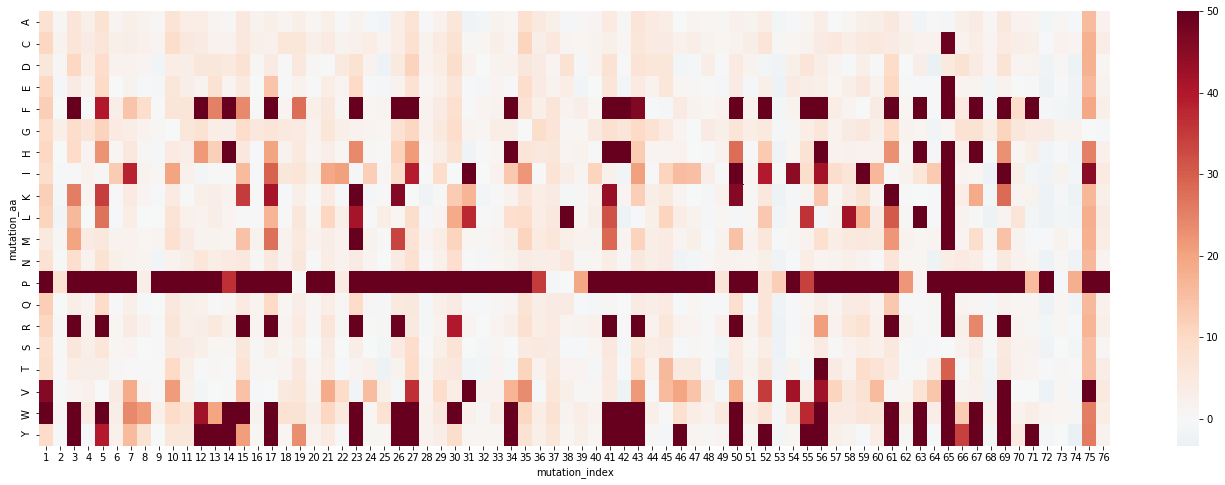

In [19]:
seaborn.heatmap(
    result_frame.pivot("mutation_aa", "mutation_index", "delta_total_score"),
    cmap="RdBu_r", center=0, vmax=50)